# Run the block to import libraries by pressing Shift and Enter at the same time.

In [106]:
import pandas as pd
import trueskill as ts
import matplotlib.pyplot as plt
from collections import Counter
import requests
import io
import csv
%matplotlib inline

In [107]:
winner_cols = ['WPlayer1', 'WPlayer2', 'WPlayer3', 'WPlayer4', 'WPlayer5']
loser_cols = ['LPlayer1', 'LPlayer2', 'LPlayer3', 'LPlayer4', 'LPlayer5']

player_cols = winner_cols + loser_cols
relevant_cols = ['Map', 'Date', 'Score', 'Team'] + winner_cols + loser_cols

# No need to run anything from here until the next section.

In [122]:
form_df = pd.read_excel("Midair_PUG_tracking (Responses).xlsx", na_filter = False)
region = 'NA'

In [123]:


form_df = pd.read_excel("Midair_PUG_tracking (Responses).xlsx", na_filter = False)
form_df = form_df[form_df['Region'] == region]

loser_df = form_df['Losing players'].str.split(',|:', expand=True)
loser_df.columns = loser_cols
loser_df

winner_df = form_df['Winning players'].str.split(',|:', expand=True)
winner_df.columns = winner_cols

def Score(series):
    return (str(series['Winning Team Score']) + "-" + str(series['Losing Team Score']))
form_df['Score'] = form_df.apply(Score, axis = 1)
form_df.rename(columns={'Winning team': 'Team'}, inplace = True)
players_df = pd.concat([winner_df, loser_df], axis = 1)
form_df = pd.concat([form_df, players_df], axis = 1)
form_df['Date'] = form_df['Date'].apply(pd.to_datetime)

form_df[player_cols] = form_df[player_cols].apply(lambda x: x.str.strip())

if region == 'AUS':
    df = pd.read_excel("cb_jester_results.xlsx")
    bittah_tourny_df = pd.read_excel("bittah_5s_july.xlsx")
    bhp_df = pd.read_excel("Midair Games.xlsx", sheet_name = 'Sheet2')
    df = pd.concat([df, bittah_tourny_df, bhp_df, form_df[relevant_cols]], axis = 0, sort = False)
    df[player_cols] = df[player_cols].apply(lambda x: x.astype(str).str.lower().str.strip())
    df.replace({'petgen': 'petty', 'basehead':'bhp', 'rr': 'devik', 'hobb': 'nasty hobbit', 'xu1':'xui', 'colonel blair|colonelblair':'cb', \
                'rulefuckdoseplease':'kroz', 'raging moose': 'raging', 'tektra':'tekra', 'launchair':'laun', 'ultralpb': 'damo', \
                'gryp|style|bakara|air|dodge|mikehunt|spacecake': 'new'}, regex = True, inplace = True)
    player_dict = ['nasty hobbit', 'ringo', 'chem', 'rumble']
    
if region == 'NA':
    tea_df = pd.read_excel("tea_games.xlsx")
    sharp_df = pd.read_excel("Midair Games.xlsx")[tea_df.columns[:-1]]
    byo5_df = pd.read_excel("byo5_jp.xlsx")
    stork_df = pd.read_excel("stork_stats.xlsx")
    yami_df = pd.read_excel("yami_moth.xlsx")
    lockjaw_fyr_df = pd.read_excel("lockjaw_fyr.xlsx")
    df = pd.concat([tea_df, sharp_df, byo5_df, stork_df, yami_df, lockjaw_fyr_df], axis = 0, sort = False)
    df = pd.concat([df, form_df], axis = 0, sort = False).copy()
    df[player_cols] = df[player_cols].apply(lambda x: x.astype(str).str.lower())

    player_dict = ['stork', 'sparkle', 'scar', 'iced', 'b3d', 'bed', 'pika', 'icehawk', 'debug', 'joe', \
               'implo', 'dae', 'jon osc', 'skip', 'ringo', 'sharp', 'ramses', 'jimmy', 'yods', 'chem', \
               'lock', 'void', 'mista b', 'osc', 'anarchy', 'tyler']

for player in player_dict:
    df[player_cols] = df[player_cols].replace({'(.*)' + player + '(.*)': player}, regex = True)

    df[player_cols] = df[player_cols].replace({'couch' : 'boris', 'b3d':'bed', 'cargo': 'esprit', 'pissface': 'giohm', 'osc': 'immie', \
             'v23': 'v22', 'patrick': 'dae', 'pat': 'moose', 'shreq': 'schreq', \
           'bootswfur|synergizer bunny|ludang|total|sun dog|vitalica|loanwolf32|jeffreee|wristfracture|swoot|kevinator|intense|kromatic|superfam|cykon|chocotaco|debug|sauon|jfw20|wrightrj|hasslehof|cohen|extcy|robbie|ramses|mysterium|brotein|germy the syphilis|raybidet|arrow|missd|mcnibbles|riley|pancak3s|bro\.scrubamtiskaw': 'newb', \
           'efx|krayvok|ucan|devil|proj': 'decent'}, regex = True)



In [124]:
df.drop_duplicates().shape

(423, 21)

In [125]:
df.to_pickle(region + '_combined_midair_games.p')

# Read in Data
Choose your region in the cell below. Then, run everything from here to the bottom by pressing Shift + Enter multiple times. Pay attention to the "profile_player" function

In [126]:
region = 'NA' # change this to NA or AUS for whichever region you want
df = pd.read_pickle(region + '_combined_midair_games.p')


In [127]:
def str_winning_team(series):
    return str(sorted(series[winner_cols]))
df['str_winning_team'] = df.apply(str_winning_team, axis = 1)


def str_losing_team(series):
    return str(sorted(series[loser_cols]))
df['str_losing_team'] = df.apply(str_losing_team, axis = 1)

df['Date'] = df['Date'].apply(pd.to_datetime)
df['Month'] = df['Date'].dt.month

df.drop_duplicates(subset = ['Month', 'Map', 'Team', 'str_winning_team', 'str_losing_team'], inplace = True)

df[player_cols] = df[player_cols].applymap(str)

players = list(set([item for sublist in df[player_cols].values.tolist() for item in sublist]))

players_ts = dict(zip(players, [ts.Rating() for i in players]))
players_ts_time = {player: [] for player in players}


df = df.sort_values(by = 'Date', ascending = True)

df['Map'] = df['Map'].str.lower()

# Create TrueSkill Rankings

In [128]:
for i, row in df.iterrows():
    # Find ratings in dictionary
    winner_list = list(row[['WPlayer1', 'WPlayer2', 'WPlayer3', 'WPlayer4', 'WPlayer5']])
    loser_list = list(row[['LPlayer1', 'LPlayer2', 'LPlayer3', 'LPlayer4', 'LPlayer5']])
    t1 = [players_ts[player] for player in winner_list]
    t2 = [players_ts[player] for player in loser_list]
    
    # Get ratings after match
    a, b = (ts.rate([t1, t2], ranks=[0, 1]))
    
    if row['Team'] == 'Tie':
        a, b = (ts.rate([t1, t2], ranks=[0, 0]))

    # Update ratings in dictionary (not necessary to split winners and losers, but easier to read and debug)
    for i, player in enumerate(winner_list):
        players_ts[player] = a[i]
        players_ts_time[player].append(a[i].mu)
    for i, player in enumerate(loser_list):
        players_ts[player] = b[i]
        players_ts_time[player].append(b[i].mu)

In [129]:

sorted_rating_list = sorted(((value.mu, key) for (key,value) in players_ts.items()), reverse = True)

# Ratings
There are a lot of choices for rating systems. Popular rating systems include elo, glicko2, and trueskill. I opted to use TrueSkill since it's the only one that handles greater than 1v1 cases.

Mu represents the estimate of the true rating of a player. Sigma represents the uncertainty factor regarding the estimate of mu. This is often just as important. A player who won 3 out of 3 games but should have only won 2 out of 3 would have a high mu but would still retain a high sigma (low sigma). The algorithm takes into account whether the teams are stacked by calculating its own estimation of what the outcome of the match should be, based on the initial ratings of the players coming into the match.

Additional details can be found here: [Layman explanation](https://wiki.faforever.com/index.php?title=How_Trueskill_works), [Technical Explanation](https://www.moserware.com/assets/computing-your-skill/The%20Math%20Behind%20TrueSkill.pdf).

#### Players sorted by unadjusted TrueSkill rating (ie. no correction for sigma aka uncertainty)

In [130]:
sorted_rating_list

[(40.45750403443864, 'berserker'),
 (39.681267076664305, 'sharp'),
 (37.14470089975524, 'stork'),
 (35.2617082069084, 'rtcll'),
 (34.99189039802056, 'tea'),
 (33.06021147999439, 'joe'),
 (32.74942578092723, 'jimmy'),
 (32.58225482331984, 'nark'),
 (31.66788672349475, 'melur'),
 (30.674480780361947, 'soundguy'),
 (30.604894426999067, 'boris'),
 (30.587062117691026, 'implo'),
 (30.31800001710341, 'swordfish'),
 (30.001249374839524, 'izza'),
 (29.73508933361954, 'icehawk'),
 (29.668186316673175, 'moose'),
 (28.939115563347244, 'ringo'),
 (28.748085073616746, 'sin'),
 (28.7452999340542, 'missb'),
 (28.516820161393174, 'anarchy'),
 (28.14345110856257, 'logic'),
 (27.849603649122283, 'fire'),
 (27.78833394964818, 'decent'),
 (27.68357647062326, 'jp'),
 (27.657303450965273, 'descolada'),
 (27.610638212903613, 'fox'),
 (27.60339543381208, 'bed'),
 (27.39754540995565, 'pixel_matter'),
 (27.39754540995565, 'dæ'),
 (27.194926979493673, 'apsteadyhands'),
 (27.16535816720044, 'newbxyz'),
 (27.01736

#### Players sorted by TrueSkill adjusted rating, with add'l vals of mu and sigma

In [131]:
rating_sigma_list = sorted(((round(value.mu, 1), round(value.sigma, 1), key) for (key,value) in players_ts.items()), reverse = True)
sorted([(round((item[0] - 1.5*item[1]),2), item[0], item[1], item[2]) for item in rating_sigma_list], reverse = True)


[(37.15, 39.7, 1.7, 'sharp'),
 (35.55, 40.5, 3.3, 'berserker'),
 (30.65, 37.1, 4.3, 'stork'),
 (29.6, 35.0, 3.6, 'tea'),
 (29.4, 32.7, 2.2, 'jimmy'),
 (28.55, 35.3, 4.5, 'rtcll'),
 (26.95, 33.1, 4.1, 'joe'),
 (26.7, 30.6, 2.6, 'implo'),
 (25.8, 29.7, 2.6, 'moose'),
 (25.2, 30.3, 3.4, 'swordfish'),
 (24.8, 32.6, 5.2, 'nark'),
 (24.5, 28.1, 2.4, 'logic'),
 (24.2, 31.7, 5.0, 'melur'),
 (24.0, 29.7, 3.8, 'icehawk'),
 (23.85, 30.6, 4.5, 'boris'),
 (23.85, 27.6, 2.5, 'fox'),
 (23.75, 28.7, 3.3, 'sin'),
 (22.75, 28.9, 4.1, 'ringo'),
 (22.1, 26.6, 3.0, 'chem'),
 (21.45, 30.0, 5.7, 'izza'),
 (21.4, 27.7, 4.2, 'jp'),
 (21.4, 26.2, 3.2, 'absolute'),
 (21.4, 24.7, 2.2, 'esprit'),
 (20.95, 30.7, 6.5, 'soundguy'),
 (20.9, 27.8, 4.6, 'decent'),
 (20.8, 25.0, 2.8, 'cyrus'),
 (20.55, 28.5, 5.3, 'anarchy'),
 (20.45, 23.6, 2.1, 'dae'),
 (20.4, 27.6, 4.8, 'bed'),
 (20.4, 25.8, 3.6, 'v22'),
 (20.2, 24.4, 2.8, 'yami'),
 (20.15, 28.7, 5.7, 'missb'),
 (20.1, 25.8, 3.8, 'kevin'),
 (19.7, 22.4, 1.8, 'iced'),
 (

#### Records for players sorted by rank

In [102]:
[(item[1], df[winner_cols].isin([item[1]]).any(axis = 1).sum(), df[loser_cols].isin([item[1]]).any(axis = 1).sum()) for item in sorted_rating_list]

[('godog', 14, 10),
 ('bhp', 14, 5),
 ('cb', 30, 12),
 ('zoidberg', 11, 2),
 ('rain', 4, 0),
 ('kustom', 7, 7),
 ('damo', 64, 36),
 ('fyr', 3, 2),
 ('sickfest', 3, 1),
 ('devik', 44, 32),
 ('dae', 9, 6),
 ('moose', 5, 6),
 ('tyler', 1, 0),
 ('laun', 33, 28),
 ('nonreg', 2, 2),
 ('xandrax', 1, 1),
 ('cyrus', 4, 3),
 ('petty', 34, 48),
 ('neogenetix', 27, 30),
 ('manlover', 1, 1),
 ('pyre', 3, 3),
 ('raging', 3, 2),
 ('confusion', 8, 7),
 ('cantara', 4, 1),
 ('danger', 5, 4),
 ('sajent', 2, 1),
 ('ringo', 3, 4),
 ('nasty hobbit', 34, 39),
 ('tamtim', 23, 17),
 ('dose', 24, 21),
 ('tea', 2, 4),
 ('jester', 37, 37),
 ('kroz', 13, 17),
 ('chem', 10, 10),
 ('xui', 13, 15),
 ('bloby', 6, 8),
 ('tekra', 1, 3),
 ('nexgen', 8, 13),
 ('xan', 7, 10),
 ('ambient', 1, 3),
 ('new', 5, 7),
 ('iced', 4, 7),
 ('nuts', 15, 21),
 ('tonks', 14, 23),
 ('skewa', 0, 6),
 ('seldom', 3, 8),
 ('rumble', 1, 6),
 ('gregyeah', 19, 50)]

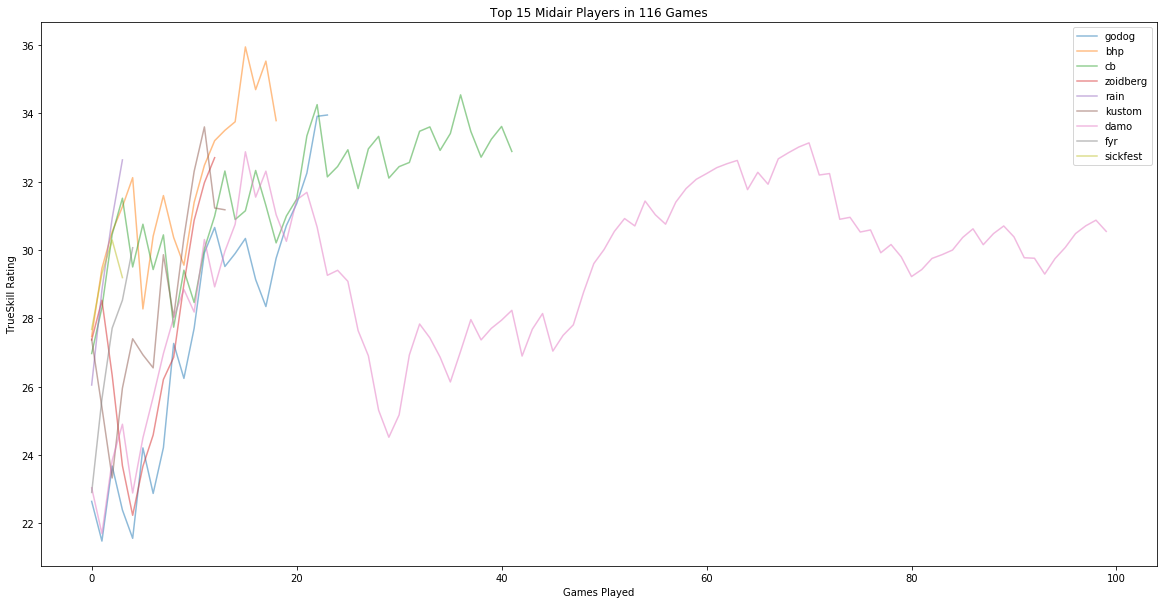

In [103]:
plotted_players = [item[1] for item in sorted_rating_list[0:9]]
plt.figure(figsize=(20,10))
for i, player in enumerate(plotted_players):
    plt.plot(players_ts_time[player], alpha=0.5)
    
plt.title("Top 15 Midair Players in " + str(df.shape[0]) + ' Games')
plt.xlabel('Games Played')
plt.ylabel('TrueSkill Rating')
plt.legend(plotted_players)
plt.show()

In [135]:
def profile_player(target, partner_list = False, partner = False, opponent_list = False, opponent = False):
    profile_df = df[df[player_cols].isin([target]).any(axis = 1)]
    profile_df
    print (target + "'s record is: " + str(df[winner_cols].isin([target]).any(axis = 1).sum()) + " - " + \
           str(df[loser_cols].isin([target]).any(axis = 1).sum()))
    
    rank_ts = [(i+1, item[0]) for i, item in enumerate(sorted_rating_list) if item[1] == target][0]
    #print (target + ' is ranked ' + str(rank_ts[0]) + ' out of ' + str(len(sorted_rating_list)) + \
    #      ', with TrueSkill score of ' + str(round(rank_ts[1], 3)) + ' and uncertainty of ' + str(round(players_ts[target].sigma, 3)))
    record_df = pd.concat([df[df[winner_cols].isin([target]).any(axis = 1)]['Map'].value_counts(), df[df[loser_cols].isin([target]).any(axis = 1)]['Map'].value_counts()], axis = 1, sort = True)
    record_df.columns = ['Wins', 'Losses']
    record_df.fillna(0, inplace = True)
    record_df.Wins = record_df.Wins.astype(int)
    record_df.Losses = record_df.Losses.astype(int)
    print (record_df)
    
    winner_partners_dict = Counter(df[df[winner_cols].isin([target]).any(axis = 1)][winner_cols].values.flatten())
    loser_partners_dict = Counter(df[df[loser_cols].isin([target]).any(axis = 1)][loser_cols].values.flatten())
    
    if partner_list is not False:
        ds = [winner_partners_dict, loser_partners_dict]
        d = {}
        for k in winner_partners_dict:
            d[k] = tuple(d[k] for d in ds)
            
        for k in loser_partners_dict:
            if k not in d:
                d[k] = tuple(d[k] for d in ds)
        print('\n' + target + "'s record when playing with these players:")
        print(list(zip(sorted(d, key=lambda x: d[x], reverse=True), sorted(d.values(), reverse = True))))

    if partner is not False:
        print ('\n' + target + ' has ' + str(winner_partners_dict[partner]) + ' wins and ' + \
               str(loser_partners_dict[partner]) + ' losses with ' + partner)
        
    winner_vs_opponents_dict = Counter(df[df[winner_cols].isin([target]).any(axis = 1)][loser_cols].values.flatten())
    loser_vs_opponents_dict = Counter(df[df[loser_cols].isin([target]).any(axis = 1)][winner_cols].values.flatten())
    
    if opponent_list is not False:
        ds = [winner_vs_opponents_dict, loser_vs_opponents_dict]
        d = {}
        for k in winner_vs_opponents_dict:
            d[k] = tuple(d[k] for d in ds)
        for k in loser_vs_opponents_dict:
            if k not in d:
                d[k] = tuple(d[k] for d in ds)
        print('\n' + target + "'s record when playing against these players:")
        print(list(zip(sorted(d, key=lambda x: d[x], reverse=True), sorted(d.values(), reverse = True))))
        #print(sorted(d, key=lambda x: d[x], reverse=True))
        
    if opponent is not False:
        print ('\n' + target + ' has ' + str(winner_vs_opponents_dict[opponent]) + ' wins ' + \
               str(loser_vs_opponents_dict[opponent]) + ' losses against ' + opponent)


In [166]:
profile_player(target = 'moose', partner_list = True, partner = 'dae', opponent_list = True, opponent = 'iced')

moose's record is: 54 - 36
             Wins  Losses
brynhildr       4       3
elite          15       6
exhumed         3       0
hypothermia     0       1
iguana          3       4
ingonyama       4       3
kryosis         7       9
minora         12       6
nightflare      1       0
outpost         3       3
sunset          1       1

moose's record when playing with these players:
[('moose', (54, 36)), ('sharp', (35, 10)), ('joe', (23, 4)), ('icehawk', (22, 2)), ('stork', (18, 0)), ('boris', (7, 2)), ('future', (6, 9)), ('squid', (6, 6)), ('esprit', (6, 5)), ('dose', (5, 5)), ('fox', (5, 3)), ('respa', (5, 1)), ('jimmy', (4, 5)), ('implo', (4, 4)), ('tree', (4, 4)), ('bed', (4, 2)), ('absolute', (4, 2)), ('nark', (4, 0)), ('fray', (4, 0)), ('iced', (3, 10)), ('dae', (3, 7)), ('newb', (3, 5)), ('tea', (3, 3)), ('berserker', (3, 3)), ('logic', (3, 3)), ('chem', (3, 1)), ('scar', (3, 1)), ('sparkle', (2, 4)), ('lock', (2, 4)), ('mista b', (2, 2)), ('jahman', (2, 2)), ('dalton', (2, 2)

In [172]:
import itertools
import math
BETA = 4.1666
def win_probability(team1, team2):
    delta_mu = sum(r.mu for r in team1) - sum(r.mu for r in team2)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1, team2))
    size = len(team1) + len(team2)
    denom = math.sqrt(size * (BETA * BETA) + sum_sigma)
    trueskill = ts.global_env()
    return trueskill.cdf(delta_mu / denom)


In [173]:
def win_prob(series):
    return win_probability([players_ts[series['WPlayer1']], players_ts[series['WPlayer2']], players_ts[series['WPlayer3']], \
                     players_ts[series['WPlayer4']], players_ts[series['WPlayer5']]], \
                    [players_ts[series['LPlayer1']], players_ts[series['LPlayer2']], players_ts[series['LPlayer3']], \
                     players_ts[series['LPlayer4']], players_ts[series['LPlayer5']]])

df['win_probability'] = df.apply(win_prob, axis = 1)

In [174]:
def correct_ts_prediction(series):
    return 'Yes' if series['win_probability'] > 0.5 else 'No'
df['correct_ts_prediction'] = df.apply(correct_ts_prediction, axis = 1)

In [175]:
df[df['Team'] != 'Tie']['correct_ts_prediction'].value_counts()

Yes    326
No      77
Name: correct_ts_prediction, dtype: int64

In [176]:
# win_probability([players_ts['sharp'], players_ts['joe'], players_ts['moose'], players_ts['implo'], players_ts['icehawk']],\
#                 [players_ts['dl'], players_ts['stork'], players_ts['berserker'], players_ts['logic'], players_ts['sin']])